In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import json

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import model_from_json

# unused for now, to be used for ROC analysis
from sklearn.metrics import roc_curve, auc



# the size of the images in the PCAM dataset
IMAGE_SIZE = 96


In [2]:
def get_pcam_generators(base_dir, train_batch_size=32, val_batch_size=32):

     # dataset parameters
     TRAIN_PATH = os.path.join(base_dir, 'train+val', 'train')
     VALID_PATH = os.path.join(base_dir, 'train+val', 'valid')

     RESCALING_FACTOR = 1./255
     
     # instantiate data generators
     datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)

     train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode='binary')

     val_gen = datagen.flow_from_directory(VALID_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=val_batch_size,
                                             class_mode='binary',
                                             shuffle=False)
     
     return train_gen, val_gen

In [3]:
def get_model(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64):


     # build the model
     model = Sequential()

     model.add(Conv2D(first_filters, kernel_size, activation = 'relu', padding = 'same', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
     model.add(MaxPool2D(pool_size = pool_size)) 

     model.add(Conv2D(second_filters, kernel_size, activation = 'relu', padding = 'same'))
     model.add(MaxPool2D(pool_size = pool_size))

     model.add(Flatten())
     model.add(Dense(64, activation = 'relu'))
     model.add(Dense(1, activation = 'sigmoid'))
     
    
     # compile the model
     model.compile(SGD(lr=0.01, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])

     return model

In [4]:
# get the model
model = get_model()

# get the data generators
train_gen, val_gen = get_pcam_generators(r'C:\Users\20192653\Documents\8P361 - Project imaging\8p361-project-imaging-master\8p361-project-imaging-master\data')

C:\Users\20192653\Anaconda3\envs\8p361\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [5]:
for layer in model.layers:
    print(layer.output_shape)

(None, 96, 96, 32)
(None, 24, 24, 32)
(None, 24, 24, 64)
(None, 6, 6, 64)
(None, 2304)
(None, 64)
(None, 1)


In [6]:
# save the model and weights
model_name = 'my_first_cnn_model'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 


# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


# train the model
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

history = model.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=3,
                    callbacks=callbacks_list)

Epoch 1/3
4500/4500 [==============================] - ETA: 0s - loss: 0.4741 - accuracy: 0.7773
Epoch 1: val_loss improved from inf to 0.43162, saving model to my_first_cnn_model_weights.hdf5
4500/4500 [==============================] - 991s 220ms/step - loss: 0.4741 - accuracy: 0.7773 - val_loss: 0.4316 - val_accuracy: 0.8054
Epoch 2/3
4500/4500 [==============================] - ETA: 0s - loss: 0.3904 - accuracy: 0.8273
Epoch 2: val_loss improved from 0.43162 to 0.40600, saving model to my_first_cnn_model_weights.hdf5
4500/4500 [==============================] - 437s 97ms/step - loss: 0.3904 - accuracy: 0.8273 - val_loss: 0.4060 - val_accuracy: 0.8158
Epoch 3/3
4500/4500 [==============================] - ETA: 0s - loss: 0.3417 - accuracy: 0.8535
Epoch 3: val_loss improved from 0.40600 to 0.32352, saving model to my_first_cnn_model_weights.hdf5
4500/4500 [==============================] - 496s 110ms/step - loss: 0.3417 - accuracy: 0.8535 - val_loss: 0.3235 - val_accuracy: 0.8562


In [7]:
import winsound
winsound.Beep(1000,1000)

# Exercise 1

In [8]:
model = tensorflow.keras.models.load_model('my_first_cnn_model_weights.hdf5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 64)                1

In [9]:
y_pred_keras=model.predict(val_gen).ravel()

In [10]:
y_true = val_gen.labels

In [11]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

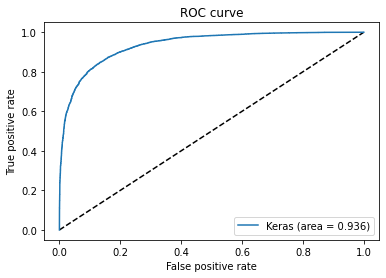

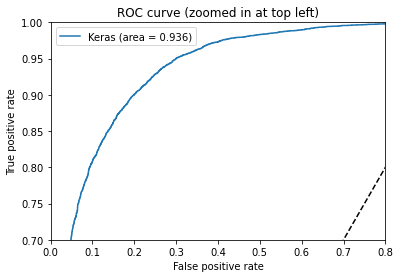

In [12]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.8)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

## Exercise 2

In [79]:
def get_model2(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64):


     # build the model
     model = Sequential()

     model.add(Conv2D(first_filters, kernel_size, activation = 'relu', padding = 'same', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
     model.add(MaxPool2D(pool_size = pool_size)) 

     model.add(Conv2D(second_filters, kernel_size, activation = 'relu', padding = 'same'))
     model.add(MaxPool2D(pool_size = pool_size))
     model.add(Conv2D(64, [6,6], activation = 'relu', padding = 'valid'))
     model.add(Conv2D(1,[1,1],activation='sigmoid', padding='same'))
    
     # compile the model
     model.compile(SGD(lr=0.01, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])
     model.add(Flatten())

     return model
    
model2 = get_model2()
model2.summary()


Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_133 (Conv2D)         (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_86 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_134 (Conv2D)         (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_135 (Conv2D)         (None, 1, 1, 64)          147520    
                                                                 
 conv2d_136 (Conv2D)         (None, 1, 1, 1)         

In [65]:
for layer in model2.layers:
    print(layer.output_shape)

(None, 96, 96, 32)
(None, 24, 24, 32)
(None, 24, 24, 64)
(None, 6, 6, 64)
(None, 1, 1, 64)
(None, 1, 1, 1)


In [69]:
# save the model and weights
model_name = 'my_second_cnn_model'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model2.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 


# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


# train the model
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

history = model2.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=3,
                    callbacks=callbacks_list)

Epoch 1/3
4500/4500 [==============================] - ETA: 0s - loss: 0.4786 - accuracy: 0.7740
Epoch 1: val_loss improved from inf to 0.43433, saving model to my_second_cnn_model_weights.hdf5
4500/4500 [==============================] - 417s 93ms/step - loss: 0.4786 - accuracy: 0.7740 - val_loss: 0.4343 - val_accuracy: 0.8049
Epoch 2/3
4500/4500 [==============================] - ETA: 0s - loss: 0.3951 - accuracy: 0.8257
Epoch 2: val_loss improved from 0.43433 to 0.34679, saving model to my_second_cnn_model_weights.hdf5
4500/4500 [==============================] - 1236s 275ms/step - loss: 0.3951 - accuracy: 0.8257 - val_loss: 0.3468 - val_accuracy: 0.8490
Epoch 3/3
4500/4500 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8527
Epoch 3: val_loss improved from 0.34679 to 0.33089, saving model to my_second_cnn_model_weights.hdf5
4500/4500 [==============================] - 352s 78ms/step - loss: 0.3410 - accuracy: 0.8527 - val_loss: 0.3309 - val_accuracy: 0.8558


why: feature learning? (not sure because same behaviour)
butit is nice to only use convolutions
nstead of putting 2304 in a row and connecting them all to 64 others =~ 147456 parameters (ergens 1 erbij om 147520 te krijgen)
a 6x6 kernel can be used on 64 filters to create 64 new filters -> 6*6*64*64 =~ 147456 parameters
then a 1x1 kernel can be used on these 64 filters to create one final filter, this one can be flattened.

Cool to only use convolution?

computational efficiency? but no because equal parameters

    